In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chemical_embeddings_path = "/content/drive/Shareddrives/CS224W_Final_Project/chemical_embeddings_full.zip"
protein_embeddings_path = "/content/drive/Shareddrives/CS224W_Final_Project/protein_embeddings.zip"



In [ ]:
import zipfile

# Specify the path to your zip file
chemical_zip_file_path = chemical_embeddings_path
protein_zip_file_path = protein_embeddings_path

with zipfile.ZipFile(chemical_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/Shareddrives/CS224W_Final_Project/embeddings/chemical_embeddings")
    print("Chemical embeddings extracted successfully.")

with zipfile.ZipFile(protein_zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/Shareddrives/CS224W_Final_Project/embeddings/protein_embeddings")
    print("Protein embeddings extracted successfully.")

Chemical embeddings extracted successfully.


In [ ]:
chemical_chemical_link = "/content/drive/Shareddrives/CS224W_Final_Project/chemical_chemical.links.detailed.v5.0.tsv"
protein_protein_link = "/content/drive/Shareddrives/CS224W_Final_Project/9606.protein.physical.links.detailed.v12.0.txt"
protein_chemical_link = "/content/drive/Shareddrives/CS224W_Final_Project/9606.protein_chemical.links.detailed.v5.0.tsv"
chemical_action = "/content/drive/Shareddrives/CS224W_Final_Project/9606.actions.v5.0.tsv"

In [ ]:
df_action = pd.read_csv(chemical_action, sep="\t")
df_chemical_chemical_link = pd.read_csv(chemical_chemical_link, sep="\t")
df_protein_protein_link = pd.read_csv(protein_protein_link, sep=" ")
df_protein_chemical_link = pd.read_csv(protein_chemical_link, sep="\t")

<Axes: >

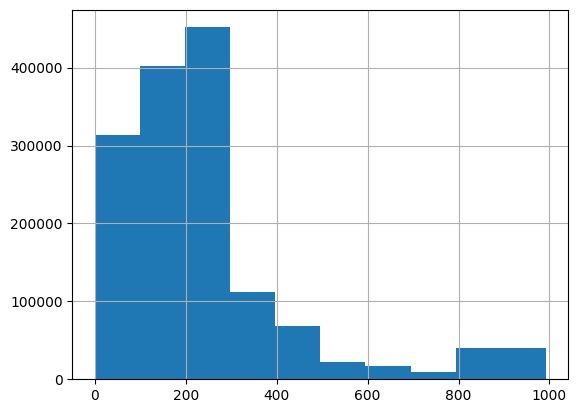

In [ ]:
df_protein_protein_link.experimental.hist()

In [ ]:
filtered_chemicals = df_action[(df_action["mode"] == "inhibition") & (df_action["score"] > 500)].item_id_a.tolist()
filtered_chemicals = list(set([chemical for chemical in filtered_chemicals if "9606" not in chemical]))
print(len(filtered_chemicals))

12446


In [ ]:
df_chemical_chemical_link_filtered = df_chemical_chemical_link[df_chemical_chemical_link.chemical1.isin(filtered_chemicals) & df_chemical_chemical_link.chemical2.isin(filtered_chemicals)]
df_chemical_chemical_link_filtered = df_chemical_chemical_link_filtered[df_chemical_chemical_link_filtered.combined_score > 400]

In [ ]:
import pickle
with open("/content/drive/Shareddrives/CS224W_Final_Project/chemicals_dict.pkl", "rb") as f:
    chemical_dict = pickle.load(f)

In [ ]:
df_protein_chemical_link_filtered = df_protein_chemical_link[df_protein_chemical_link.chemical.isin(filtered_chemicals)]
df_protein_chemical_link_filtered = df_protein_chemical_link_filtered[df_protein_chemical_link_filtered.experimental > 0]

In [ ]:
df_protein_protein_link_filtered = df_protein_protein_link[df_protein_protein_link.protein1.isin(df_protein_chemical_link_filtered.protein) & df_protein_protein_link.protein2.isin(df_protein_chemical_link_filtered.protein)]
df_protein_protein_link_filtered = df_protein_protein_link_filtered[df_protein_protein_link_filtered.experimental > 0]

In [ ]:
filtered_proteins = df_protein_chemical_link_filtered.protein.unique().tolist()

In [ ]:
protein_embeddings_path = "/content/protein_embeddings/data/stringdb_embeddings"
protein_embeddings_dict = {}
missing_embeddings = []
for protein in filtered_proteins:
  if  "{}.pt".format(protein) in os.listdir(protein_embeddings_path):
    protein_embeddings_dict[protein] = torch.load(f"{protein_embeddings_path}/{protein}.pt",  map_location=torch.device('cpu'))["embeddings"]
  else:
    missing_embeddings.append(protein)


<ipython-input-150-8819660badc4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  protein_embeddings_dict[protein] = torch.load(f"{protein_embeddings_path}/{protein}.pt",  m

In [ ]:
with open("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/protein_embeddings_dict.pkl", "wb") as f:
    pickle.dump(protein_embeddings_dict, f)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
def embed_smile(smile, model):
    inputs = tokenizer(smile, return_tensors="pt", padding=True, truncation=True, max_length=180).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Averaging over token embeddings
    return embeddings

In [ ]:
df_chems = pd.read_csv("/content/drive/Shareddrives/CS224W_Final_Project/chemicals.v5.0.filtered.tsv", sep="\t", header = None)

In [ ]:
df_chems_filtered = df_chems[df_chems[0].isin(filtered_chemicals)]

In [ ]:
smiles = df_chems_filtered[3].to_list()
smiles_chunk = [smiles[i:i+100] for i in range(0, len(smiles), 100)]

In [ ]:
embeddings = []

for chunk_index, chunk in enumerate(smiles_chunk):
  print(chunk_index)
  embeddings.append(embed_smile(chunk, model))

In [ ]:
catted_embeddings = torch.cat(embeddings, dim=0)

In [ ]:
chemical_embeddings_dict = {}
missing_chem_embeddings = []
for i, chem in df_chems_filtered.reset_index().iterrows():
  print(i)
  if chem[0] in filtered_chemicals:
    chemical_embeddings_dict[chem[0]] = catted_embeddings[i].detach().cpu().numpy()
  else:
    missing_chem_embeddings.append(chem[0])
#

In [ ]:
import pickle
# save pickle
with open("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/chemical_embeddings_dict.pkl", "wb") as f:
    pickle.dump(chemical_embeddings_dict, f)

In [ ]:
protein_embeddings_dict = {}
with open("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/protein_embeddings_dict.pkl", "rb") as f:
    protein_embeddings_dict = pickle.load(f)

In [ ]:
df_protein_chemical_link_filtered = df_protein_chemical_link_filtered[df_protein_chemical_link_filtered.chemical.isin(chemical_embeddings_dict.keys())]
df_protein_chemical_link_filtered = df_protein_chemical_link_filtered[df_protein_chemical_link_filtered.protein.isin(protein_embeddings_dict.keys())]
df_protein_chemical_link_filtered.reset_index(drop=True).to_csv("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/protein_chemical_link_filtered.csv")

In [ ]:
df_protein_protein_link_filtered = df_protein_protein_link_filtered[df_protein_protein_link_filtered.protein1.isin(protein_embeddings_dict.keys())]
df_protein_protein_link_filtered = df_protein_protein_link_filtered[df_protein_protein_link_filtered.protein2.isin(protein_embeddings_dict.keys())]
df_protein_protein_link_filtered = df_protein_protein_link_filtered.reset_index(drop=True)
df_protein_protein_link_filtered.to_csv("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/protein_protein_link_filtered.csv")

In [ ]:
df_chemical_chemical_link_filtered = df_chemical_chemical_link_filtered[df_chemical_chemical_link_filtered.chemical1.isin(chemical_embeddings_dict.keys())]
df_chemical_chemical_link_filtered = df_chemical_chemical_link_filtered[df_chemical_chemical_link_filtered.chemical2.isin(chemical_embeddings_dict.keys())]
df_chemical_chemical_link_filtered = df_chemical_chemical_link_filtered.reset_index(drop=True)
df_chemical_chemical_link_filtered.to_csv("/content/drive/Shareddrives/CS224W_Final_Project/processed_data/chemical_chemical_link_filtered.csv")